In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/Padam-0/cluster_t-shirt_sizing/master/data.csv') 

remove_cols = []

for i in df.columns:
    if 3900 - df.loc[:,i].astype(bool).sum() > 2000:
        remove_cols.append(i)

df = df.drop(remove_cols, axis = 'columns')

df.head()

,PERSON #,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,...,TWIN,BIRTH ORDER,MOTHERS OCCUPATION,FATHERS OCCUPATION,MOTHERS EDUCATION,FATHERS EDUCATION,YEARS IN COMMUNITY,ANTHROPOMETER NO,CALIPER NO,GIRTH NO
0,Person #1,155,1033,582,184,306,0,498,133,282,...,2,1,7,7,4,4,23,1,0,1
1,Person #2,176,1039,606,199,311,0,506,138,273,...,2,1,7,7,4,4,7,1,0,1
2,Person #3,230,1112,594,239,387,0,512,138,309,...,2,1,7,7,4,4,6,1,0,1
3,Person #4,165,997,542,194,312,0,489,140,253,...,2,1,11,9,3,4,4,1,0,1
4,Person #5,150,997,524,190,321,0,473,132,273,...,2,1,7,7,4,4,5,1,0,1


In [30]:
df = df.loc[:, ['ERECT SITTING HEIGHT', 'WEIGHT', 'SEX', 'SHOULDER BREADTH', 'AGE IN MONTHS', 'CHEST CIRCUMFERENCE']]
df.head()

,ERECT SITTING HEIGHT,WEIGHT,SEX,SHOULDER BREADTH,AGE IN MONTHS,CHEST CIRCUMFERENCE
0,582,155,2,282,50,526
1,606,176,1,273,51,564
2,594,230,2,309,53,601
3,542,165,2,253,46,532
4,524,150,2,273,41,501


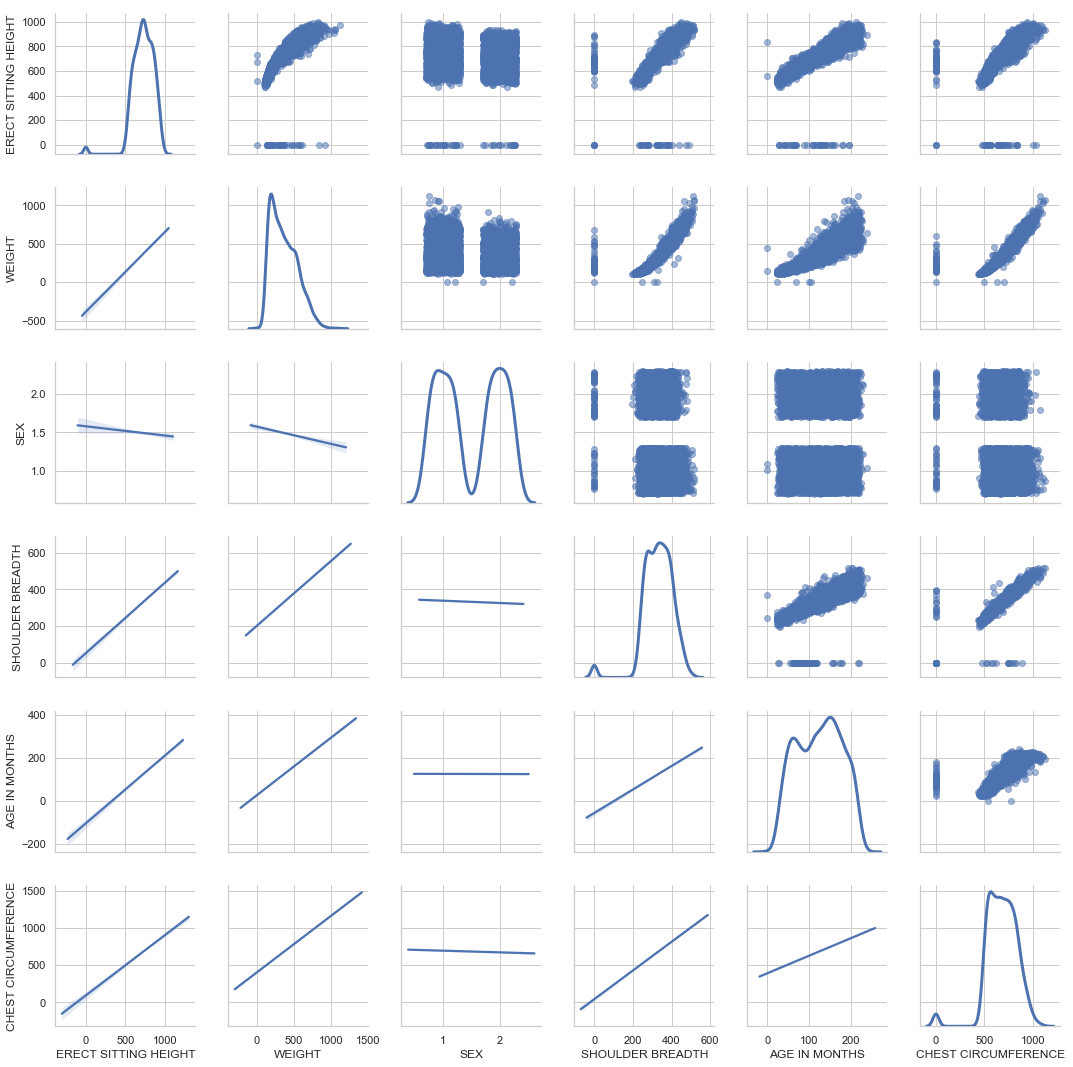

In [34]:
# Make a copy of the data to add jitter to and plot.
df_jittered = df.loc[:, 'ERECT SITTING HEIGHT':'CHEST CIRCUMFERENCE'].dropna()
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'SHOULDER BREADTH and Age')

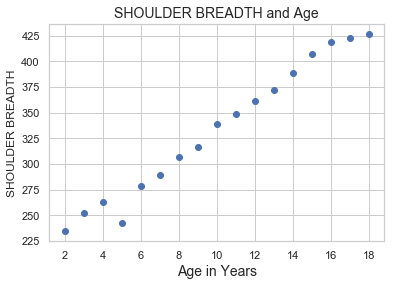

In [31]:
shoulder_data = df[['SHOULDER BREADTH', 'AGE IN MONTHS']]
shoulder_data['YEAR'] = weight_data['AGE IN MONTHS'].apply(lambda x: x//12)
x = list(shoulder_data.groupby('YEAR').mean().index[1:-2])
y = list(shoulder_data.groupby('YEAR').mean()['SHOULDER BREADTH'][1:-2])

plt.scatter(x, y, data=shoulder_data)
#plt.xticks([])
plt.xlabel('Age in Years',fontsize=14)
plt.ylabel('SHOULDER BREADTH')
plt.title('SHOULDER BREADTH and Age',fontsize=14)

                      ERECT SITTING HEIGHT    WEIGHT       SEX  \
ERECT SITTING HEIGHT              1.000000  0.784402 -0.026198   
WEIGHT                            0.784402  1.000000 -0.075652   
SEX                              -0.026198 -0.075652  1.000000   
SHOULDER BREADTH                  0.681255  0.826102 -0.092929   
AGE IN MONTHS                     0.798742  0.894860 -0.004763   
CHEST CIRCUMFERENCE               0.683269  0.844905 -0.081597   

                      SHOULDER BREADTH  AGE IN MONTHS  CHEST CIRCUMFERENCE  
ERECT SITTING HEIGHT          0.681255       0.798742             0.683269  
WEIGHT                        0.826102       0.894860             0.844905  
SEX                          -0.092929      -0.004763            -0.081597  
SHOULDER BREADTH              1.000000       0.779299             0.915670  
AGE IN MONTHS                 0.779299       1.000000             0.785489  
CHEST CIRCUMFERENCE           0.915670       0.785489             1.000000 

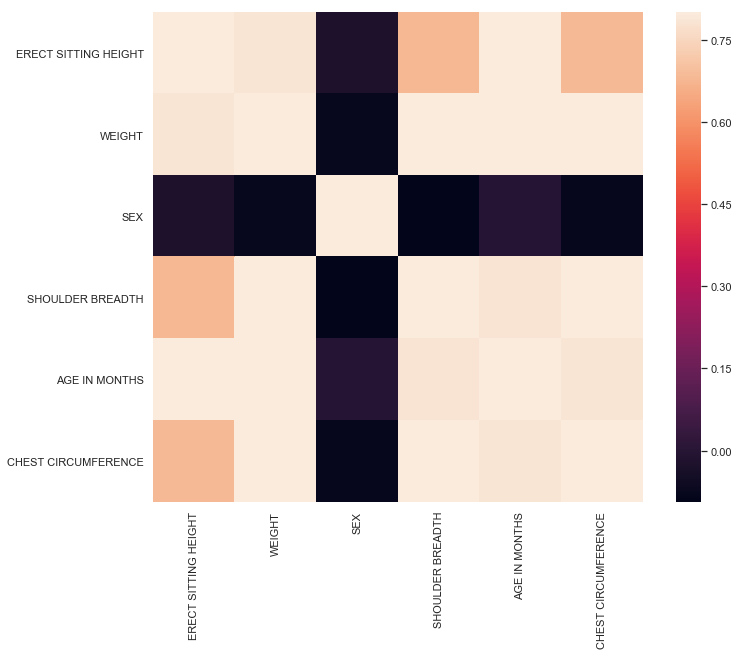

In [35]:
# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

Text(0.5,1,'Weight and Age')

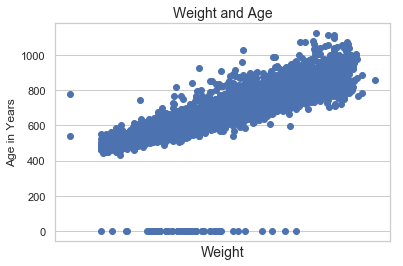

In [8]:
y = df['CHEST CIRCUMFERENCE']
x = df['AGE IN MONTHS']

plt.scatter(x, y, data=df)
plt.xticks([])
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Age in Years')
plt.title('Weight and Age',fontsize=14)

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'SHOULDER BREADTH and Age')

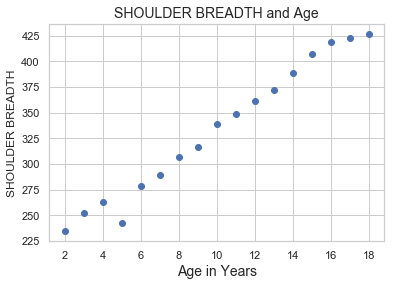

In [12]:
shoulder_data = df[['SHOULDER BREADTH', 'AGE IN MONTHS']]
shoulder_data['YEAR'] = weight_data['AGE IN MONTHS'].apply(lambda x: x//12)
x = list(shoulder_data.groupby('YEAR').mean().index[1:-2])
y = list(shoulder_data.groupby('YEAR').mean()['SHOULDER BREADTH'][1:-2])

plt.scatter(x, y, data=shoulder_data)
#plt.xticks([])
plt.xlabel('Age in Years',fontsize=14)
plt.ylabel('SHOULDER BREADTH')
plt.title('SHOULDER BREADTH and Age',fontsize=14)


C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Weight and Age')

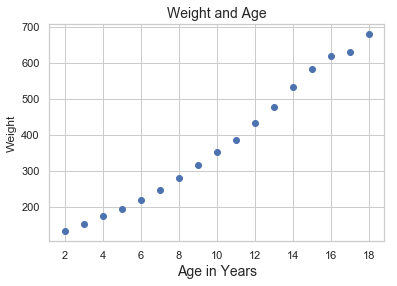

In [11]:
weight_data = df[['WEIGHT', 'AGE IN MONTHS']]
weight_data['YEAR'] = weight_data['AGE IN MONTHS'].apply(lambda x: x//12)
x = list(weight_data.groupby('YEAR').mean().index[1:-2])
y = list(weight_data.groupby('YEAR').mean()['WEIGHT'][1:-2])

plt.scatter(x, y, data=weight_data)
#plt.xticks([])
plt.xlabel('Age in Years',fontsize=14)
plt.ylabel('Weight')
plt.title('Weight and Age',fontsize=14)


In [41]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

X = df.loc[:, ['ERECT SITTING HEIGHT', 'WEIGHT', 'SEX', 'SHOULDER BREADTH', 'AGE IN MONTHS','CHEST CIRCUMFERENCE']]
sklearn_pca = PCA(n_components=6)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [8.56543704e-01 8.32065006e-02 4.56642084e-02 9.08361354e-03
 5.49907753e-03 2.89609703e-06]


## Erect Sitting Height explains 87.8% of the variance in the datset. Since everything aside from Sex (which accounts for only 4% of the variance) is correlated with one another, I'll keep only Erect Sitting Height and Sex as my features. I will aim to predict chest circumference.

In [39]:
df2 = df[['ERECT SITTING HEIGHT', 'SEX', 'CHEST CIRCUMFERENCE']]
df2.head()

,ERECT SITTING HEIGHT,SEX,CHEST CIRCUMFERENCE
0,582,2,526
1,606,1,564
2,594,2,601
3,542,2,532
4,524,2,501


Text(0.5,1,'Average purchase by Age')

<Figure size 1440x360 with 0 Axes>

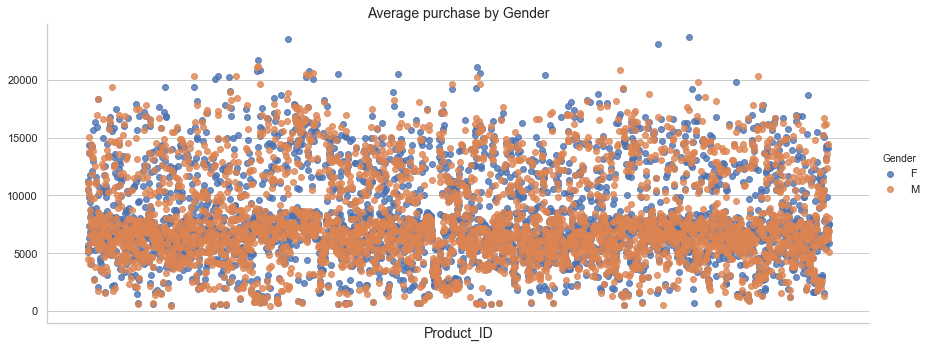

<Figure size 1440x360 with 0 Axes>

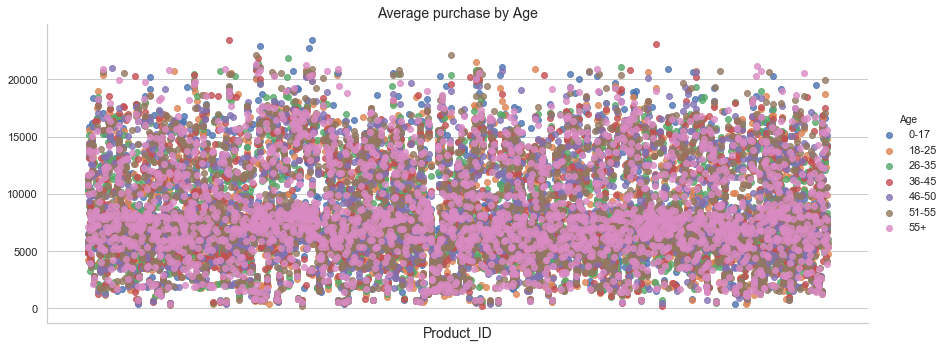

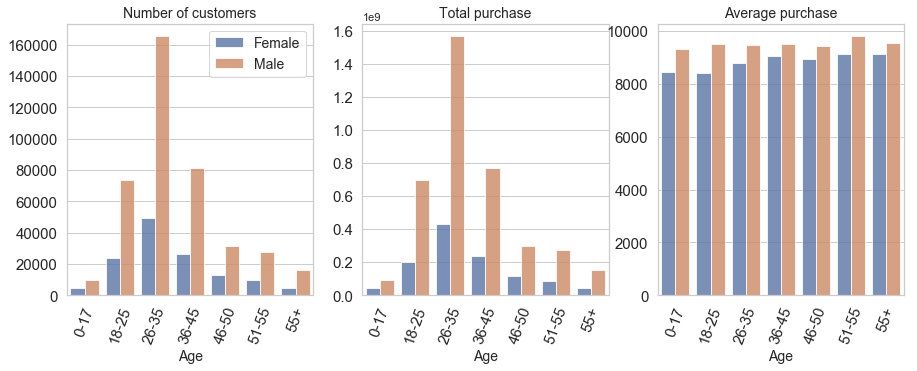

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.countplot('Age',order=age_order,hue='Gender',data=df,alpha = 0.8)
plt.xlabel('Age',fontsize=14)
plt.ylabel('')
plt.xticks(rotation=70)
plt.title('Number of customers',fontsize=14)
plt.legend(['Female','Male'],frameon=True,fontsize=14)
plt.tick_params(labelsize=15)
plt.subplot(132)
df_Tpurchase_by_Age = df.groupby(['Age','Gender']).agg({'Purchase':np.sum}).reset_index()
sns.barplot('Age','Purchase',hue='Gender',data=df_Tpurchase_by_Age,alpha = 0.8)
plt.xlabel('Age',fontsize=14)
plt.ylabel('')
plt.xticks(rotation=70)
plt.title('Total purchase',fontsize=14)
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)
plt.subplot(133)
df_Apurchase_by_Age = df.groupby(['Age','Gender']).agg({'Purchase':np.mean}).reset_index()
sns.barplot('Age','Purchase',hue='Gender',data=df_Apurchase_by_Age,alpha = 0.8)
plt.xlabel('Age',fontsize=14)
plt.ylabel('')
plt.xticks(rotation=70)
plt.title('Average purchase',fontsize=14)
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)

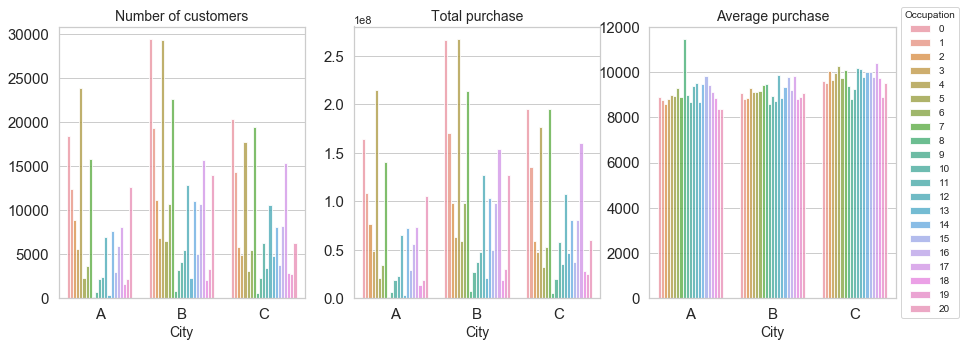

In [13]:
city_order = ['A','B','C']
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.countplot('City_Category',order=city_order,hue='Occupation',data=df,alpha = 0.8)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)
plt.title('Number of customers',fontsize=14)
plt.subplot(132)
df_Tpurchase_by_City = df.groupby(['City_Category','Occupation']).agg({'Purchase':np.sum}).reset_index()
sns.barplot('City_Category','Purchase',hue='Occupation',data=df_Tpurchase_by_City,alpha = 0.8)
plt.title('Total purchase',fontsize=14)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)
plt.subplot(133)
df_Apurchase_by_City = df.groupby(['City_Category','Occupation']).agg({'Purchase':np.mean}).reset_index()
sns.barplot('City_Category','Purchase',hue='Occupation',data=df_Apurchase_by_City,alpha = 0.8)
plt.title('Average purchase',fontsize=14)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend(title='Occupation',frameon=True,fontsize=10,bbox_to_anchor=(1,0.5), loc="center left")
plt.tick_params(labelsize=15)

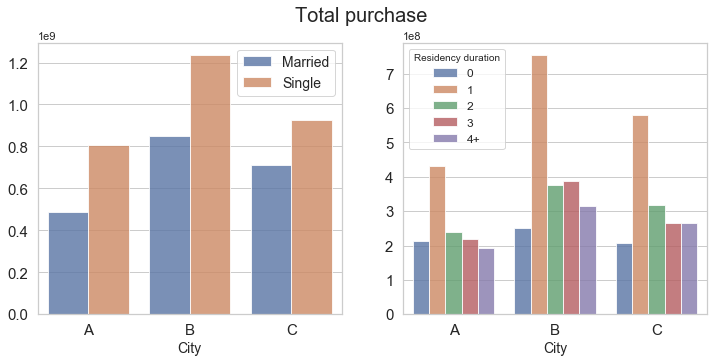

In [14]:
df['Marital_Status_label']=np.where(df['Marital_Status'] == 0,'Single','Married')
df_Tpurchase_by_City_Marital = df.groupby(['City_Category','Marital_Status_label']).agg({'Purchase':np.sum}).reset_index()
df_Tpurchase_by_City_Stay = df.groupby(['City_Category','Stay_In_Current_City_Years']).agg({'Purchase':np.sum}).reset_index()
fig = plt.figure(figsize=(12,5))
fig.suptitle('Total purchase',fontsize=20)
plt.subplot(121)
sns.barplot('City_Category','Purchase',hue='Marital_Status_label',data=df_Tpurchase_by_City_Marital,alpha = 0.8)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend(frameon=True,fontsize=14)
plt.tick_params(labelsize=15)
plt.subplot(122)
sns.barplot('City_Category','Purchase',hue='Stay_In_Current_City_Years',data=df_Tpurchase_by_City_Stay,alpha = 0.8)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend(title='Residency duration',frameon=True,fontsize=12,loc=2)
plt.tick_params(labelsize=15)
df.drop('Marital_Status_label',axis=1,inplace=True)

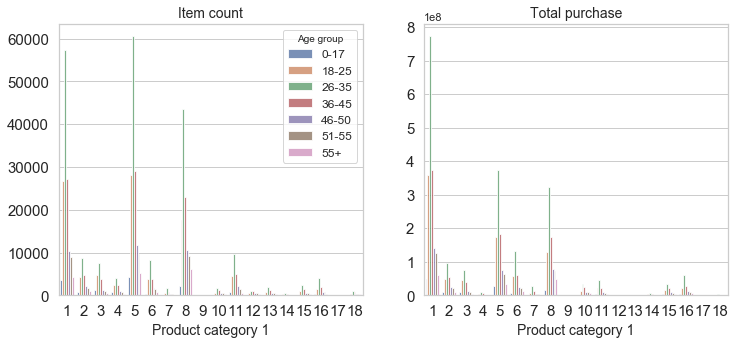

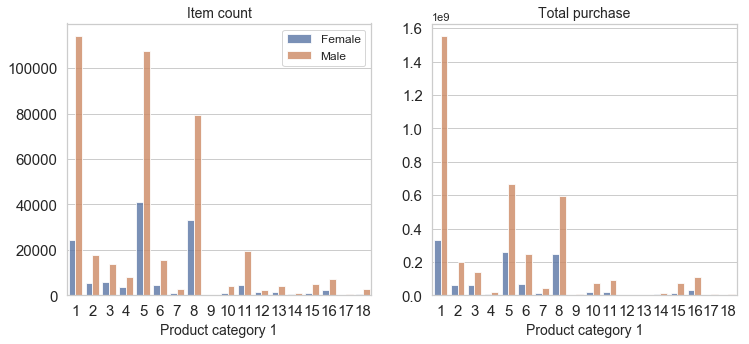

In [15]:
df_Tpurchase_by_PC1_Age = df.groupby(['Product_Category_1','Age']).agg({'Purchase':np.sum}).reset_index()
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
sns.countplot('Product_Category_1',hue='Age',data=df,alpha = 0.8,hue_order=age_order)
plt.title('Item count',fontsize=14)
plt.xlabel('Product category 1',fontsize=14)
plt.ylabel('')
plt.legend(title='Age group',frameon=True,fontsize=12)
plt.tick_params(labelsize=15)
plt.subplot(122)
sns.barplot('Product_Category_1','Purchase',hue='Age',data=df_Tpurchase_by_PC1_Age,alpha = 0.8)
plt.title('Total purchase',fontsize=14)
plt.xlabel('Product category 1',fontsize=14)
plt.ylabel('')
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)

df_Tpurchase_by_PC1_Gender = df.groupby(['Product_Category_1','Gender']).agg({'Purchase':np.sum}).reset_index()
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
sns.countplot('Product_Category_1',hue='Gender',data=df,alpha = 0.8)
plt.title('Item count',fontsize=14)
plt.xlabel('Product category 1',fontsize=14)
plt.ylabel('')
plt.legend(['Female','Male'],frameon=True,fontsize=12)
plt.tick_params(labelsize=15)
plt.subplot(122)
sns.barplot('Product_Category_1','Purchase',hue='Gender',data=df_Tpurchase_by_PC1_Gender,alpha = 0.8)
plt.title('Total purchase',fontsize=14)
plt.xlabel('Product category 1',fontsize=14)
plt.ylabel('')
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)